# Downloading the data and computing log-returns

[*********************100%***********************]  1 of 1 completed


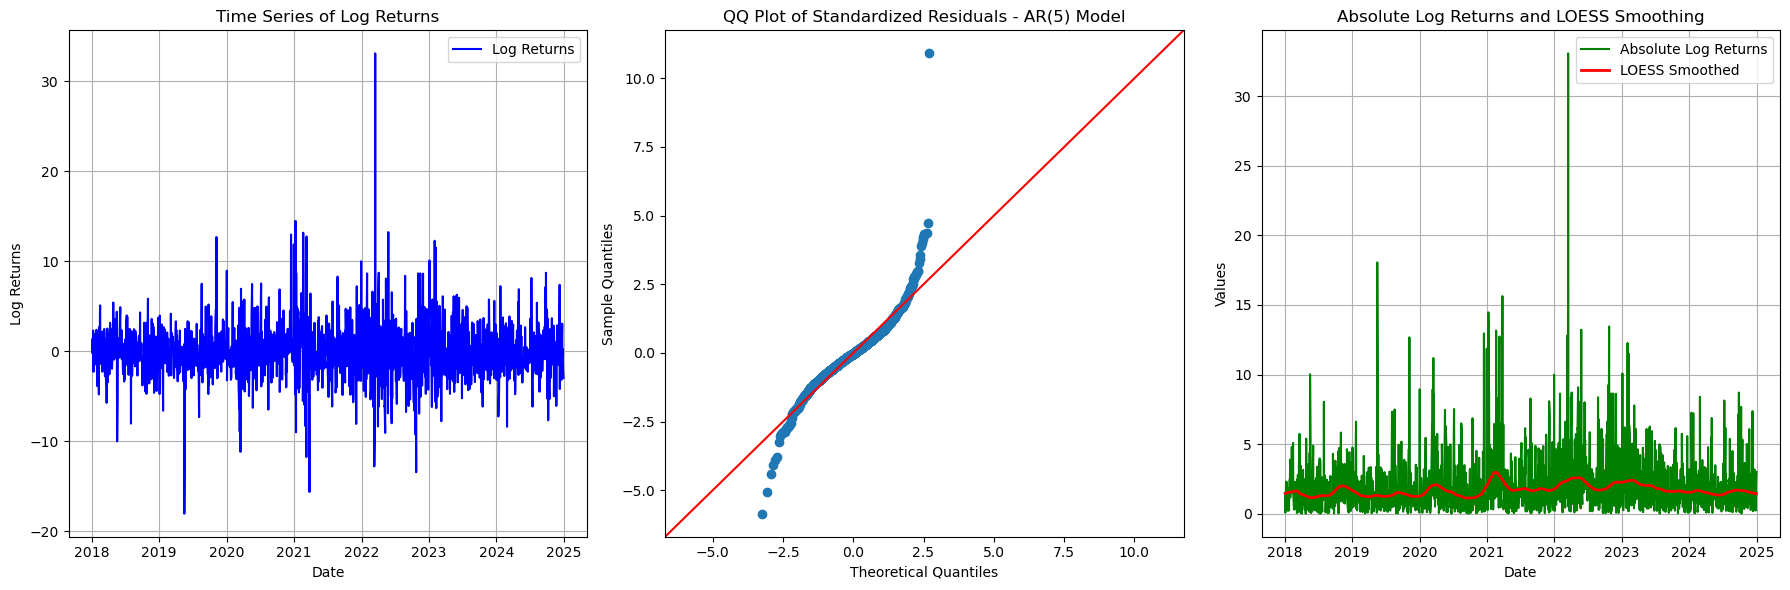

In [7]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# Step 1: Fetch Apple stock data
apple_data = yf.download('BIDU', start='2018-01-01', end='2024-12-31')

# Step 2: Calculate log returns
bidu_close = apple_data['Close']
bidu_log_returns = np.log(bidu_close / bidu_close.shift(1)).dropna() * 100

# Step 3: Fit AR(5) model using the ARCH library
ar_model = arch_model(bidu_log_returns, mean='AR', lags=5, vol='Constant')
model_result = ar_model.fit(disp='off')

# Step 4: Standardize residuals
residuals = model_result.resid
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Step 5: Apply LOESS smoothing to absolute log returns
absolute_log_returns = np.abs(bidu_log_returns)
absolute_log_returns_values = absolute_log_returns.values.ravel()  # Ensure it's a 1D array
loess_smoothed = lowess(absolute_log_returns_values, np.arange(len(absolute_log_returns_values)), frac=0.05)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Time Series of Log Returns
axs[0].plot(bidu_log_returns.index, bidu_log_returns, color='blue', label="Log Returns")
axs[0].set_title("Time Series of Log Returns")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Log Returns")
axs[0].grid()
axs[0].legend()

# QQ Plot of Standardized Residuals
sm.qqplot(standardized_residuals, line='45', ax=axs[1])
axs[1].set_title("QQ Plot of Standardized Residuals - AR(5) Model")

# Time Series of Absolute Log Returns and LOESS Smoothing
axs[2].plot(absolute_log_returns.index, absolute_log_returns_values, color='green', label="Absolute Log Returns")
axs[2].plot(absolute_log_returns.index, loess_smoothed[:, 1], color='red', label="LOESS Smoothed", linewidth=2)
axs[2].set_title("Absolute Log Returns and LOESS Smoothing")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Values")
axs[2].grid()
axs[2].legend()



plt.tight_layout()
plt.savefig('intro.png', dpi=300)
plt.show()


# Fitting an AR(1) with the arch library



In [8]:
from arch import arch_model
ar1_model = arch_model(bidu_log_returns, mean='AR', lags=1, vol='Constant').fit()

# Step 4: Print the model summary
print(ar1_model.summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                   BIDU   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:          Constant Variance   Log-Likelihood:               -4455.10
Distribution:                  Normal   AIC:                           8916.21
Method:            Maximum Likelihood   BIC:                           8932.63
                                        No. Observations:                 1758
Date:                Tue, Jan 28 2025   Df Residuals:                     1756
Time:                        12:19:27   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const          -0.0610  7.254e-02     -0.841      0.

# Fitting an AR(1) with a T-distribution for Errors

In [9]:
ar1_t_model = arch_model(bidu_log_returns, mean='AR', lags=1, vol='Constant', dist='t')
ar1_t_result = ar1_t_model.fit(disp='off')

# Step 4: Print the model summary
print(ar1_t_result.summary())

                        AR - Constant Variance Model Results                        
Dep. Variable:                         BIDU   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.001
Vol Model:                Constant Variance   Log-Likelihood:               -4283.48
Distribution:      Standardized Student's t   AIC:                           8574.96
Method:                  Maximum Likelihood   BIC:                           8596.84
                                              No. Observations:                 1758
Date:                      Tue, Jan 28 2025   Df Residuals:                     1756
Time:                              12:19:49   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

# QQ-plots of Residuals

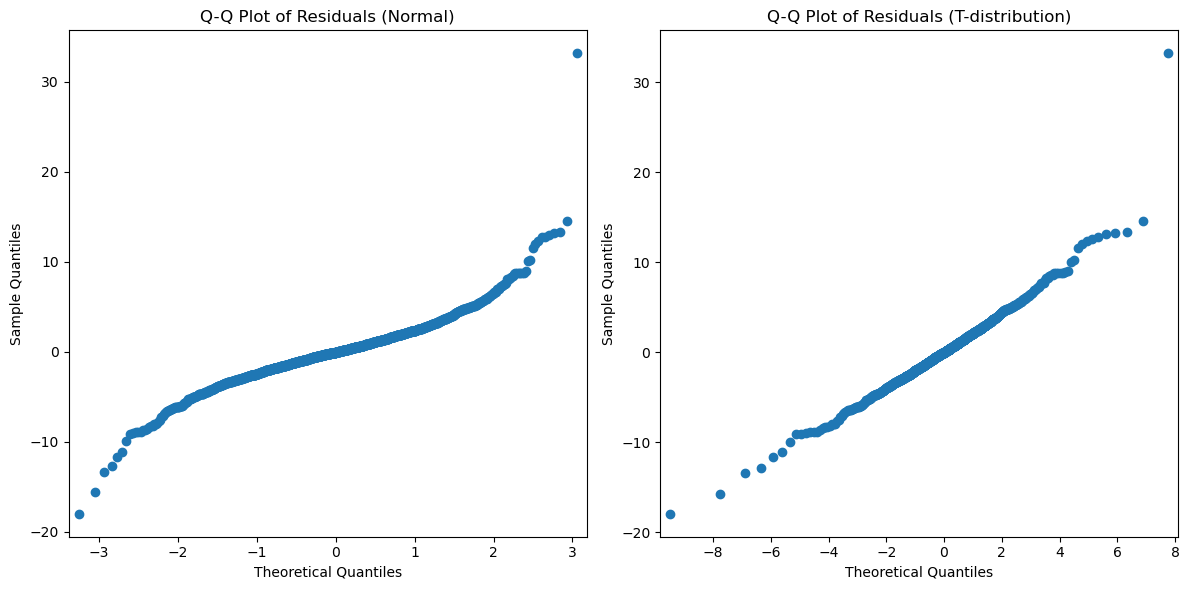

In [10]:
from scipy.stats import t

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

normal_residuals = ar1_model.resid
t_residuals = ar1_t_result.resid
df = ar1_t_result.params['nu']

# Q-Q Plot for Normal Residuals
sm.qqplot(normal_residuals, line='s', ax=axs[0])
axs[0].set_title('Q-Q Plot of Residuals (Normal)')

# Q-Q Plot for T-distributed Residuals
sm.qqplot(t_residuals, dist=t, distargs=(df,), line='s', ax=axs[1])
axs[1].set_title('Q-Q Plot of Residuals (T-distribution)')

plt.tight_layout()
plt.savefig("qqplots")
plt.show()

# Residual Plots from arch

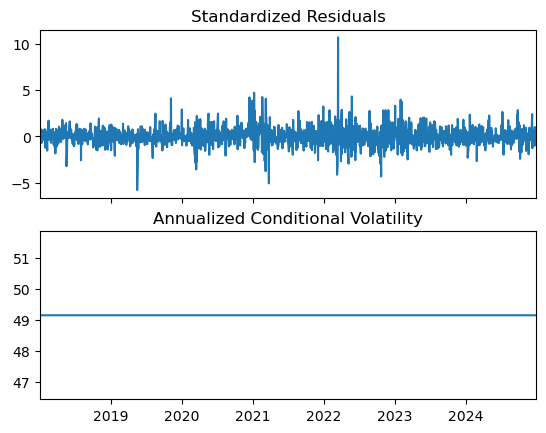

In [11]:
ar1_t_result.plot(annualize='D')
plt.show()  # Display the plot

# Fit an AR(1) + ARCH(1) Model




In [12]:
arch_model_t = arch_model(bidu_log_returns, mean='AR', lags=1, vol='ARCH', p=1, dist='t')
arch_result_t = arch_model_t.fit(disp='off')

# Print summary of the model
print(arch_result_t.summary())

                              AR - ARCH Model Results                               
Dep. Variable:                         BIDU   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.001
Vol Model:                             ARCH   Log-Likelihood:               -4263.32
Distribution:      Standardized Student's t   AIC:                           8536.64
Method:                  Maximum Likelihood   BIC:                           8564.00
                                              No. Observations:                 1758
Date:                      Tue, Jan 28 2025   Df Residuals:                     1756
Time:                              12:21:41   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

# Output from ARCH

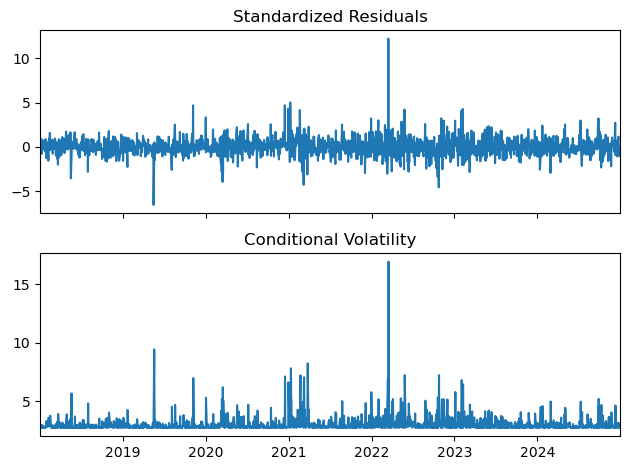

In [13]:
fig = arch_result_t.plot()
plt.tight_layout()
plt.savefig("outs.png")
plt.show()

# ACF of Residuals



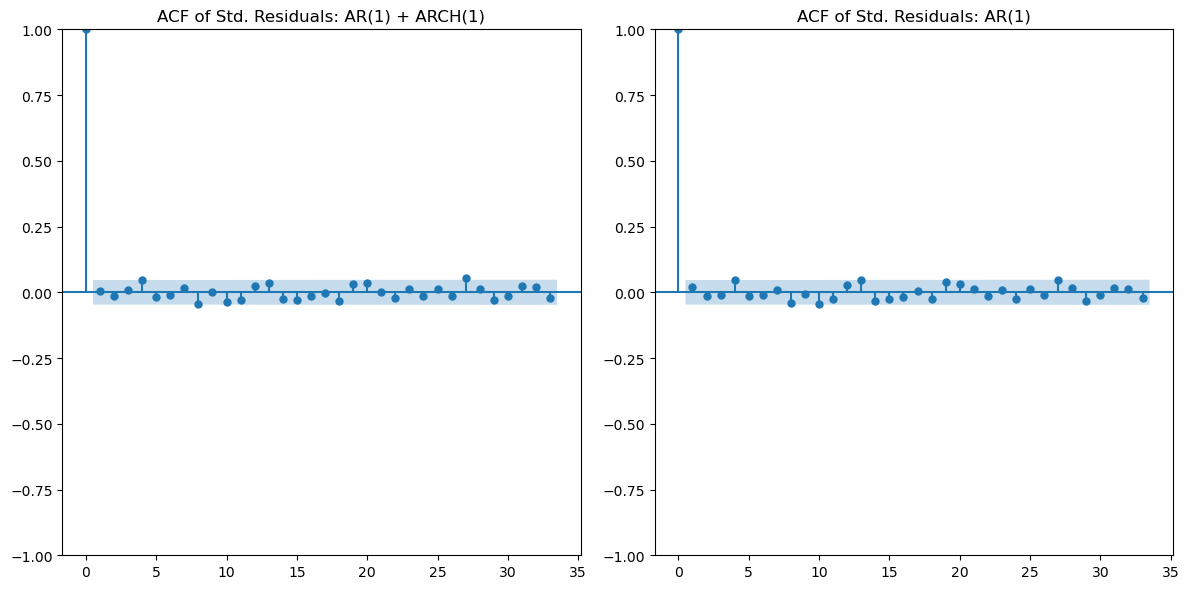

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

# Fit AR(1) + ARCH(1) model with T-errors
arch_model_t = arch_model(bidu_log_returns, mean='AR', lags=1, vol='ARCH', p=1, dist='t')
arch_result_t = arch_model_t.fit(disp='off')

# Step 3: Fit AR(1) model without ARCH component
ar_model = arch_model(bidu_log_returns, mean='AR', lags=1, vol='Constant', dist='t')
ar_result = ar_model.fit(disp='off')

# Step 4: Extract standardized residuals
arch_std_resid = arch_result_t.std_resid.dropna()  # Standardized residuals from ARCH
ar_resid = ar_result.std_resid.dropna()  # Residuals from AR

# Step 5: Plot ACFs side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# ACF of standardized residuals from AR(1) + ARCH(1)
plot_acf(arch_std_resid, ax=axs[0], title="ACF of Std. Residuals: AR(1) + ARCH(1)")

# ACF of residuals from AR(1)
plot_acf(ar_resid, ax=axs[1], title="ACF of Std. Residuals: AR(1)")

plt.tight_layout()
plt.savefig("acfs.png")
plt.show()


# Fitting various AR(p) + ARCH(q) Models

In [16]:
import pandas as pd
results = []
for p in range(8):  # AR lags from 0 to 7
    for q in range(1,8):  # ARCH lags from 0 to 7
        try:
            model = arch_model(bidu_log_returns, mean='AR', lags=p, vol='ARCH', p=q, dist='t')
            result = model.fit(disp='off')
            bic = result.bic
            results.append((p, q, bic))
            print(f"AR({p}) + ARCH({q}) - BIC: {bic:.2f}")
        except Exception as e:
            print(f"AR({p}) + ARCH({q}) failed: {e}")

# Step 3: Find the best combination based on BIC
results_df = pd.DataFrame(results, columns=['AR_Lags', 'ARCH_Lags', 'BIC'])
best_model = results_df.loc[results_df['BIC'].idxmin()]

# Print the best model
print("\nBest Model:")
print(f"AR({int(best_model['AR_Lags'])}) + ARCH({int(best_model['ARCH_Lags'])}) - BIC: {best_model['BIC']:.2f}")

# Step 4: Fit the best model
p_best, q_best = int(best_model['AR_Lags']), int(best_model['ARCH_Lags'])
final_model = arch_model(bidu_log_returns, mean='AR', lags=p_best, vol='ARCH', p=q_best, dist='t')
final_result = final_model.fit(disp='off')

# Print the final model summary
print("\nFinal Model Summary:")
print(final_result.summary())

AR(0) + ARCH(1) - BIC: 8560.47
AR(0) + ARCH(2) - BIC: 8560.06
AR(0) + ARCH(3) - BIC: 8546.75
AR(0) + ARCH(4) - BIC: 8541.43
AR(0) + ARCH(5) - BIC: 8548.89
AR(0) + ARCH(6) - BIC: 8551.67
AR(0) + ARCH(7) - BIC: 8559.14
AR(1) + ARCH(1) - BIC: 8564.00
AR(1) + ARCH(2) - BIC: 8563.63
AR(1) + ARCH(3) - BIC: 8550.22
AR(1) + ARCH(4) - BIC: 8545.04
AR(1) + ARCH(5) - BIC: 8552.47
AR(1) + ARCH(6) - BIC: 8555.21
AR(1) + ARCH(7) - BIC: 8562.68
AR(2) + ARCH(1) - BIC: 8568.22
AR(2) + ARCH(2) - BIC: 8567.84
AR(2) + ARCH(3) - BIC: 8554.33
AR(2) + ARCH(4) - BIC: 8549.10
AR(2) + ARCH(5) - BIC: 8556.51
AR(2) + ARCH(6) - BIC: 8559.37
AR(2) + ARCH(7) - BIC: 8566.84
AR(3) + ARCH(1) - BIC: 8571.81
AR(3) + ARCH(2) - BIC: 8571.66
AR(3) + ARCH(3) - BIC: 8557.35
AR(3) + ARCH(4) - BIC: 8552.44
AR(3) + ARCH(5) - BIC: 8559.83
AR(3) + ARCH(6) - BIC: 8563.00
AR(3) + ARCH(7) - BIC: 8570.47
AR(4) + ARCH(1) - BIC: 8569.49
AR(4) + ARCH(2) - BIC: 8569.62
AR(4) + ARCH(3) - BIC: 8556.31
AR(4) + ARCH(4) - BIC: 8553.52
AR(4) + 

# Plotting the Output



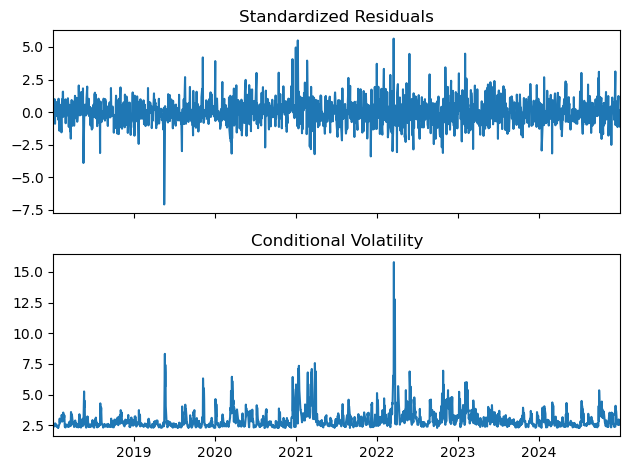

In [17]:
fig = final_result.plot()
plt.tight_layout()
plt.savefig("out-final.png")
plt.show()